#### Imports

In [1]:
import os
import re
import numpy
import matplotlib.pyplot as plot
from collections import Counter
import pickle
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers
from tensorflow.keras import backend
from tqdm import tqdm
from pympler.asizeof import asizeof

#### Constants

In [2]:
IMAGES_PATH = os.path.abspath("../data/Flickr8k/Flicker8k_Dataset/")
TRAIN_IMAGES_PATH = os.path.abspath("../data/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt")
TEST_IMAGES_PATH = os.path.abspath("../data/Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt")
RAW_CAPTION_PATH = os.path.abspath("../data/Flickr8k/Flickr8k_text/Flickr8k.token.txt")
# If not enough memory to load all  the 300-dimensional embeddings, use lower dimensional ones
GLOVE_WORD_EMBEDDINGS_PATH = os.path.abspath("../data/glove/glove.6B.100d.txt")
PROCESSED_CAPTIONS_PATH = os.path.abspath("../data/Flickr8k/preprocessed_captions.pkl")
VECTORIZED_CAPTIONS_PATH = os.path.abspath("../data/Flickr8k/vectorized_captions.pkl")
VOCABULARY_PATH = os.path.abspath("../data/Flickr8k/vocabulary.pkl")
ENCODINGS_PATH = os.path.abspath("../data/Flickr8k/encodings.pkl")
WORD_EMBEDDINGS_PATH = os.path.abspath("../data/Flickr8k/word_embeddings.pkl")
MIN_WORD_FREQ = 8

# Data Preprocessing

## Data Cleaning

#### Extracting captions from Flickr8k.token.txt

In [3]:
captions = {}
with open(RAW_CAPTION_PATH, "r") as file:
    for line in file.readlines():
#         print(line)
        splits = re.compile("#\d+").split(line)
        image_name = splits[0]
        caption = splits[1]
        caption = re.sub(r"\n+|\t+|\s{2,}", "", caption)
        if image_name not in captions:
            captions[image_name] = []
        captions[image_name].append(caption)
captions

{'1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'T

#### Sample display of images along with their captions

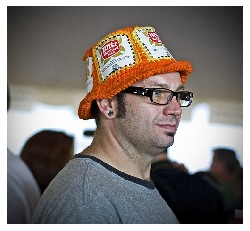

A man in an orange hat starring at something .
A man wears an orange hat and glasses .
A man with gauges and glasses is wearing a Blitz hat .
A man with glasses is wearing a beer can crocheted hat .
The man with pierced ears is wearing glasses and an orange hat .




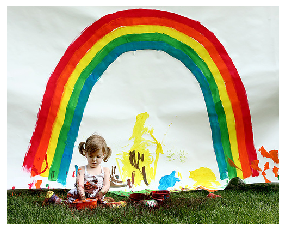

A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
A little girl is sitting in front of a large painted rainbow .
A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
There is a girl with pigtails sitting in front of a rainbow painting .
Young girl with pigtails painting outside in the grass .




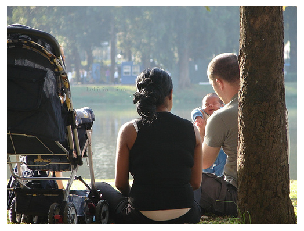

A couple and an infant , being held by the male , sitting next to a pond with a near by stroller .
A couple sit on the grass with a baby and stroller .
A couple with their newborn baby sitting under a tree facing a lake .
A man and woman care for an infant along the side of a body of water .
Couple with a baby sit outdoors next to their stroller .




In [4]:
for img in ['1007129816_e794419615.jpg', '1002674143_1b742ab4b8.jpg', '1022454428_b6b660a67b.jpg']:
    plot.imshow(plot.imread(os.path.join(IMAGES_PATH, img)))
    plot.axis('off')
    plot.show()
    print("\n".join(captions[img]))
    print("\n")

> To lowercase <br> Remove words with special characters and numbers <br> Remove special characters (punctuations) & words of unit length (might keep 'a')

In [5]:
def wordFilter(word):
    if not re.match(r"^[a-z]+$", word):
        return False
    
    if len(word) == 1 and word != "a":
        return False
    
    return True

In [6]:
words = [] 
for _, _captions in captions.items():
    for i in range(len(_captions)):
        caption = _captions[i]
        caption = caption.lower()
        _words = caption.split(" ")
        _words = list(filter(wordFilter, _words))
        _captions[i] = ' '.join(_words)
#         We will add <start> and <end> in data_generator
        _captions[i] = '<start> ' + _captions[i] + ' <end>' 
        words.extend(_words)
word_freq = Counter(words)

In [7]:
word_freq
captions

{'1000268201_693b08cb0e.jpg': ['<start> a child in a pink dress is climbing up a set of stairs in an entry way <end>',
  '<start> a girl going into a wooden building <end>',
  '<start> a little girl climbing into a wooden playhouse <end>',
  '<start> a little girl climbing the stairs to her playhouse <end>',
  '<start> a little girl in a pink dress going into a wooden cabin <end>'],
 '1001773457_577c3a7d70.jpg': ['<start> a black dog and a spotted dog are fighting <end>',
  '<start> a black dog and a dog playing with each other on the road <end>',
  '<start> a black dog and a white dog with brown spots are staring at each other in the street <end>',
  '<start> two dogs of different breeds looking at each other on the road <end>',
  '<start> two dogs on pavement moving toward each other <end>'],
 '1002674143_1b742ab4b8.jpg': ['<start> a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl <end>',
  '<start> a little girl is sitting in front of a large

> Remove words with frequency less than 5

In [8]:
vocabulary = []
for word, freq in word_freq.items():
    if(freq >= MIN_WORD_FREQ):
        vocabulary.append(word)
vocabulary.append('<start>')
vocabulary.append('<end>')
vocabulary.append('<unk>')
vocabulary.sort()
vocabulary.insert(0, '<pad>')
print(len(vocabulary))
vocabulary

2234


['<pad>',
 '<end>',
 '<start>',
 '<unk>',
 'a',
 'about',
 'above',
 'accordion',
 'across',
 'act',
 'action',
 'adult',
 'adults',
 'advertisement',
 'advertising',
 'aerial',
 'african',
 'after',
 'against',
 'aged',
 'agility',
 'ahead',
 'aiming',
 'air',
 'airborne',
 'airplane',
 'alike',
 'all',
 'alley',
 'almost',
 'alone',
 'along',
 'alongside',
 'also',
 'ambulance',
 'american',
 'amid',
 'amidst',
 'among',
 'amongst',
 'amusement',
 'an',
 'and',
 'animal',
 'animals',
 'another',
 'appear',
 'appears',
 'apple',
 'apples',
 'approaches',
 'approaching',
 'apron',
 'aqua',
 'arcade',
 'are',
 'area',
 'arena',
 'arm',
 'arms',
 'army',
 'around',
 'art',
 'artificial',
 'artist',
 'arts',
 'as',
 'ascending',
 'asian',
 'asking',
 'asleep',
 'asphalt',
 'at',
 'athlete',
 'athletic',
 'atop',
 'attached',
 'attack',
 'attempt',
 'attempting',
 'attempts',
 'attention',
 'attire',
 'atv',
 'audience',
 'autumn',
 'away',
 'babies',
 'baby',
 'back',
 'backdrop',
 'backg

#### Saving captions...

In [9]:
with open(PROCESSED_CAPTIONS_PATH, "wb") as file:
    pickle.dump(captions, file)

#### Saving vocabulary...

In [10]:
with open(VOCABULARY_PATH, "wb") as file:
    pickle.dump(vocabulary, file)

## Data Transformation (on captions)

#### Finding the length of the longest caption

In [11]:
max_length = 0
for _captions in captions.values():
    _lengths = list(map(lambda caption: len(caption.split(" ")), _captions))
    max_length = max(max_length, max(_lengths))
max_length

36

#### Word to index mapping and Index to word mapping

In [13]:
word_to_index = {}
index_to_word = {}

# word_to_index['<pad>'] = 0
# index_to_word[0] = '<pad>'

index = 0
for word in vocabulary:
    word_to_index[word] = index
    index_to_word[index] = word
    index += 1
print(word_to_index)
index_to_word

{'<pad>': 0, '<end>': 1, '<start>': 2, '<unk>': 3, 'a': 4, 'about': 5, 'above': 6, 'accordion': 7, 'across': 8, 'act': 9, 'action': 10, 'adult': 11, 'adults': 12, 'advertisement': 13, 'advertising': 14, 'aerial': 15, 'african': 16, 'after': 17, 'against': 18, 'aged': 19, 'agility': 20, 'ahead': 21, 'aiming': 22, 'air': 23, 'airborne': 24, 'airplane': 25, 'alike': 26, 'all': 27, 'alley': 28, 'almost': 29, 'alone': 30, 'along': 31, 'alongside': 32, 'also': 33, 'ambulance': 34, 'american': 35, 'amid': 36, 'amidst': 37, 'among': 38, 'amongst': 39, 'amusement': 40, 'an': 41, 'and': 42, 'animal': 43, 'animals': 44, 'another': 45, 'appear': 46, 'appears': 47, 'apple': 48, 'apples': 49, 'approaches': 50, 'approaching': 51, 'apron': 52, 'aqua': 53, 'arcade': 54, 'are': 55, 'area': 56, 'arena': 57, 'arm': 58, 'arms': 59, 'army': 60, 'around': 61, 'art': 62, 'artificial': 63, 'artist': 64, 'arts': 65, 'as': 66, 'ascending': 67, 'asian': 68, 'asking': 69, 'asleep': 70, 'asphalt': 71, 'at': 72, 'at

{0: '<pad>',
 1: '<end>',
 2: '<start>',
 3: '<unk>',
 4: 'a',
 5: 'about',
 6: 'above',
 7: 'accordion',
 8: 'across',
 9: 'act',
 10: 'action',
 11: 'adult',
 12: 'adults',
 13: 'advertisement',
 14: 'advertising',
 15: 'aerial',
 16: 'african',
 17: 'after',
 18: 'against',
 19: 'aged',
 20: 'agility',
 21: 'ahead',
 22: 'aiming',
 23: 'air',
 24: 'airborne',
 25: 'airplane',
 26: 'alike',
 27: 'all',
 28: 'alley',
 29: 'almost',
 30: 'alone',
 31: 'along',
 32: 'alongside',
 33: 'also',
 34: 'ambulance',
 35: 'american',
 36: 'amid',
 37: 'amidst',
 38: 'among',
 39: 'amongst',
 40: 'amusement',
 41: 'an',
 42: 'and',
 43: 'animal',
 44: 'animals',
 45: 'another',
 46: 'appear',
 47: 'appears',
 48: 'apple',
 49: 'apples',
 50: 'approaches',
 51: 'approaching',
 52: 'apron',
 53: 'aqua',
 54: 'arcade',
 55: 'are',
 56: 'area',
 57: 'arena',
 58: 'arm',
 59: 'arms',
 60: 'army',
 61: 'around',
 62: 'art',
 63: 'artificial',
 64: 'artist',
 65: 'arts',
 66: 'as',
 67: 'ascending',
 6

#### Obtaining padded caption vector

#### Saving vectorized captions...

## Feature Extraction

#### Loading training examples from Flickr_8k.trainImages.txt

In [28]:
with open(TRAIN_IMAGES_PATH, "r") as file:
    train_images = file.read().strip().split("\n")
print(len(train_images))
train_images

6000


['2513260012_03d33305cf.jpg',
 '2903617548_d3e38d7f88.jpg',
 '3338291921_fe7ae0c8f8.jpg',
 '488416045_1c6d903fe0.jpg',
 '2644326817_8f45080b87.jpg',
 '218342358_1755a9cce1.jpg',
 '2501968935_02f2cd8079.jpg',
 '2699342860_5288e203ea.jpg',
 '2638369467_8fc251595b.jpg',
 '2926786902_815a99a154.jpg',
 '2851304910_b5721199bc.jpg',
 '3423802527_94bd2b23b0.jpg',
 '3356369156_074750c6cc.jpg',
 '2294598473_40637b5c04.jpg',
 '1191338263_a4fa073154.jpg',
 '2380765956_6313d8cae3.jpg',
 '3197891333_b1b0fd1702.jpg',
 '3119887967_271a097464.jpg',
 '2276499757_b44dc6f8ce.jpg',
 '2506892928_7e79bec613.jpg',
 '2187222896_c206d63396.jpg',
 '2826769554_85c90864c9.jpg',
 '3097196395_ec06075389.jpg',
 '3603116579_4a28a932e2.jpg',
 '3339263085_6db9fd0981.jpg',
 '2532262109_87429a2cae.jpg',
 '2076906555_c20dc082db.jpg',
 '2502007071_82a8c639cf.jpg',
 '3113769557_9edbb8275c.jpg',
 '3325974730_3ee192e4ff.jpg',
 '1655781989_b15ab4cbff.jpg',
 '1662261486_db967930de.jpg',
 '2410562803_56ec09f41c.jpg',
 '2469498117

#### Building the model

In [40]:
%%time
backend.clear_session()
inceptionv3 = InceptionV3(weights="imagenet")
input_layer = inceptionv3.layers[0].input
output_layer = inceptionv3.layers[-1].input
inception_model = Model(inputs=input_layer, outputs=output_layer)

CPU times: user 4.91 s, sys: 131 ms, total: 5.04 s
Wall time: 8.62 s


#### Extracting encodings of the training examples

In [42]:
def get_encodings(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    img = image.img_to_array(img)
    img = preprocess_input(img)
    img = numpy.expand_dims(img, axis = 0)
    _encodings = inception_model.predict(img)[0]
    return _encodings

In [47]:
%%time
progress = tqdm(total=len(train_images), desc="Encoded", position=0)
encodings = {}
for train_image in train_images:
    _encodings = get_encodings(os.path.join(IMAGES_PATH, train_image))
    encodings[train_image] = _encodings
    progress.update(1)
print(len(encodings))
encodings

Encoded: 100%|██████████| 6000/6000 [26:58<00:00,  3.84it/s]  

6000
CPU times: user 57min 18s, sys: 34.6 s, total: 57min 53s
Wall time: 26min 58s


{'2513260012_03d33305cf.jpg': array([0.08447924, 0.09467597, 0.09230025, ..., 0.07690585, 1.4561855 ,
        0.45119122], dtype=float32),
 '2903617548_d3e38d7f88.jpg': array([0.17603184, 0.5156655 , 0.41329587, ..., 0.65110475, 0.35608873,
        0.97732365], dtype=float32),
 '3338291921_fe7ae0c8f8.jpg': array([0.16187192, 0.13512494, 0.0470786 , ..., 0.35250133, 0.2543646 ,
        0.38996497], dtype=float32),
 '488416045_1c6d903fe0.jpg': array([0.450073  , 0.07103851, 0.14107423, ..., 0.5103906 , 1.1378493 ,
        0.47370908], dtype=float32),
 '2644326817_8f45080b87.jpg': array([0.26103935, 0.8520197 , 0.03016781, ..., 0.05509175, 1.0150248 ,
        0.937017  ], dtype=float32),
 '218342358_1755a9cce1.jpg': array([0.73624265, 0.16550522, 0.12633781, ..., 0.32769346, 0.28599387,
        0.58553237], dtype=float32),
 '2501968935_02f2cd8079.jpg': array([0.15158747, 0.06291365, 1.0291824 , ..., 0.07257851, 1.0984021 ,
        0.99730563], dtype=float32),
 '2699342860_5288e203ea.jpg':

#### Saving encodings...

In [ ]:
with open(ENCODINGS_PATH, "wb") as file:
    pickle.dump(encodings, file)

## Extracting Word Embeddings

In [15]:
%%time
progress = tqdm(desc="Extracted", position=0)
_word_embeddings = {}
with open(GLOVE_WORD_EMBEDDINGS_PATH, "r") as file:
    for line in file.readlines():
        splits = line.split(" ")
        word = splits[0]
        embeddings = splits[1:]
        _word_embeddings[word] = numpy.array(embeddings)
        progress.update(1)
print(len(_word_embeddings.keys()))
_word_embeddings['the']

Extracted: 399093it [00:10, 51143.60it/s]

400001
CPU times: user 8.24 s, sys: 1.21 s, total: 9.45 s
Wall time: 11.1 s


array(['-0.038194', '-0.24487', '0.72812', '-0.39961', '0.083172',
       '0.043953', '-0.39141', '0.3344', '-0.57545', '0.087459',
       '0.28787', '-0.06731', '0.30906', '-0.26384', '-0.13231',
       '-0.20757', '0.33395', '-0.33848', '-0.31743', '-0.48336',
       '0.1464', '-0.37304', '0.34577', '0.052041', '0.44946', '-0.46971',
       '0.02628', '-0.54155', '-0.15518', '-0.14107', '-0.039722',
       '0.28277', '0.14393', '0.23464', '-0.31021', '0.086173', '0.20397',
       '0.52624', '0.17164', '-0.082378', '-0.71787', '-0.41531',
       '0.20335', '-0.12763', '0.41367', '0.55187', '0.57908', '-0.33477',
       '-0.36559', '-0.54857', '-0.062892', '0.26584', '0.30205',
       '0.99775', '-0.80481', '-3.0243', '0.01254', '-0.36942', '2.2167',
       '0.72201', '-0.24978', '0.92136', '0.034514', '0.46745', '1.1079',
       '-0.19358', '-0.074575', '0.23353', '-0.052062', '-0.22044',
       '0.057162', '-0.15806', '-0.30798', '-0.41625', '0.37972',
       '0.15006', '-0.53212', '

In [16]:
word_embeddings = numpy.zeros((len(vocabulary), 100));
for word, index in word_to_index.items():
    if index == 0:
        continue
    if word in _word_embeddings:
        word_embeddings[index-1] = _word_embeddings[word]
#     else:
#         word_embeddings[index-1] = numpy.zeros(100)
print(word_embeddings)

[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.28365  -0.6263   -0.44351  ...  0.43678  -0.82607  -0.15701 ]
 ...
 [ 0.78928   0.62846  -0.46468  ...  0.082295  0.8793   -0.08541 ]
 [-0.67634   0.16709   0.9469   ... -0.32543  -0.23453   0.23096 ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]]


#### Saving embeddings matrix...

In [18]:
with open(WORD_EMBEDDINGS_PATH, "wb") as file:
    pickle.dump(word_embeddings, file)

# Training

#### Data Generator function (for Stochastic Gradient Descent)

In [20]:
def data_generator(batch_size, captions, image_encodings, word_to_index, vocabulary_length, max_caption_length):
    count = 0
    _image_encodings = []
    input_sequence_vectors = []
    output_word_vectors = []
    while 1:
        for img, _captions in captions.items():
            for caption in _captions:
                vectorized_caption = []
#                 vectorized_caption.append(word_to_index['<start>'])
                for word in caption.split(" "):
                    if word not in word_to_index:
                        word = '<unk>'
                    vectorized_caption.append(word_to_index[word])
#                 vectorized_caption.append(word_to_index['<end>'])
                for i in range(len(vectorized_caption) - 1):
                    input_sequence_vector = vectorized_caption[:i+1]
                    input_sequence_vector = sequence.pad_sequences([input_sequence_vector], maxlen=max_caption_length, dtype='int32', padding='post', value=0)[0]
                    
                    output_word_index = vectorized_caption[i+1]
                    output_word_vector = numpy.zeros(vocabulary_length)
                    output_word_vector[output_word_index] = 1
            
                    _image_encodings.append(image_encodings[img])
                    input_sequence_vectors.append(input_sequence_vector) 
                    output_word_vectors.append(output_word_vector)
            count += 1
            if count == batch_size:
#                 print(numpy.array(_image_encodings).shape)
#                 print(numpy.array(input_sequence_vectors).shape)
#                 print(numpy.array(output_word_vectors).shape)
                yield ((numpy.array(_image_encodings), numpy.array(input_sequence_vectors)), numpy.array(output_word_vectors))
                
                count = 0
                _image_encodings = []
                input_sequence_vectors = []
                output_word_vectors = []

#### Construction of the model

In [21]:
%%time
backend.clear_session()
input_img = layers.Input(shape=(2048,))
dropout = layers.Dropout(0.5)(input_img)
dense = layers.Dense(256, activation='relu')(dropout)
model_img = dense

input_txt = layers.Input(shape=(max_length, ))
embedding = layers.Embedding(word_embeddings.shape[0], 100, mask_zero=True)(input_txt)
dropout = layers.Dropout(0.5)(embedding)
# TODO: lstm = layers.Bidirectional(layers.LSTM(256))(dropout)
lstm = layers.LSTM(256)(dropout)
model_txt = lstm

layer_merge = layers.add([model_img, model_txt])
dense = layers.Dense(256, activation='relu')(layer_merge)
output = layers.Dense(word_embeddings.shape[0], activation='softmax')(dense)

model = Model(inputs=[input_img, input_txt], outputs=output)

CPU times: user 1.43 s, sys: 140 ms, total: 1.57 s
Wall time: 2.61 s


In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 36)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 36, 100)      223400      input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

In [23]:
model.layers

#### Using the embeddings extracted from a pretrained GloVe model as weights on the embedding layer in our model

In [24]:
model.layers[2].set_weights([word_embeddings])
model.layers[2].trainable = False

#### Compiling the model

In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [26]:
image_encodings = {}
with open(ENCODINGS_PATH, "rb") as file:
    image_encodings = pickle.load(file)

In [29]:
train_captions = {}
for train_image in train_images:
    if train_image in captions:
        train_captions[train_image] = captions[train_image]
print(len(train_captions))
train_captions

6000


{'2513260012_03d33305cf.jpg': ['<start> a black dog is running after a white dog in the snow <end>',
  '<start> black dog chasing brown dog through snow <end>',
  '<start> two dogs chase each other across the snowy ground <end>',
  '<start> two dogs play together in the snow <end>',
  '<start> two dogs running through a low lying body of water <end>'],
 '2903617548_d3e38d7f88.jpg': ['<start> a little baby plays croquet <end>',
  '<start> a little girl plays croquet next to a truck <end>',
  '<start> the child is playing croquette by the truck <end>',
  '<start> the kid is in front of a car with a put and a ball <end>',
  '<start> the little boy is playing with a croquet hammer and ball beside the car <end>'],
 '3338291921_fe7ae0c8f8.jpg': ['<start> a brown dog in the snow has something hot pink in its mouth <end>',
  '<start> a brown dog in the snow holding a pink hat <end>',
  '<start> a brown dog is holding a pink shirt in the snow <end>',
  '<start> a dog is carrying something pink 

#### Training...

In [31]:
%%time
batch_size = 10
lr_updates = 3 #0.01 (10 epochs) -> 0.001 (10 epochs) -> 0.0001 (5 epochs) i
epoch_lr_map = [(10, 0.01)]
for epochs, lr in epoch_lr_map:
    model.fit_generator(data_generator(batch_size=batch_size, captions=train_captions, image_encodings=image_encodings, word_to_index=word_to_index, vocabulary_length=len(vocabulary), max_caption_length=max_length), 
                        steps_per_epoch=int(len(image_encodings)/batch_size), 
                        epochs=epochs, 
                        verbose=1)
    model.save('model.h5')
    

Epoch 1/10
600/600 [==============================] - 672s 1s/step - loss: 3.5554
Epoch 2/10
600/600 [==============================] - 649s 1s/step - loss: 3.2211
Epoch 3/10
600/600 [==============================] - 649s 1s/step - loss: 3.0449
Epoch 4/10
600/600 [==============================] - 670s 1s/step - loss: 2.9249
Epoch 5/10
600/600 [==============================] - 707s 1s/step - loss: 2.8336
Epoch 6/10
600/600 [==============================] - 744s 1s/step - loss: 2.7596
Epoch 7/10
600/600 [==============================] - 706s 1s/step - loss: 2.6990
Epoch 8/10
600/600 [==============================] - 664s 1s/step - loss: 2.6453
Epoch 9/10
600/600 [==============================] - 659s 1s/step - loss: 2.5992
Epoch 10/10
600/600 [==============================] - 658s 1s/step - loss: 2.5608
CPU times: user 5h 12min 28s, sys: 7min 31s, total: 5h 19min 59s
Wall time: 1h 53min


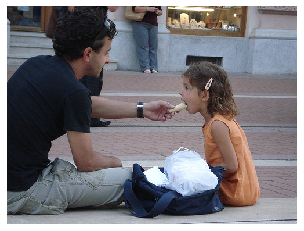

<start> a man and a woman are sitting on a bench <end>


In [67]:
# test_image_path = input("Image Path: ")
test_image_path = "/home/ram/Projects/CSE575/Project/image-captioning/data/Flickr8k/Flicker8k_Dataset/191003287_2915c11d8e.jpg"    
test_image_encodings = get_encodings(test_image_path)
input_sequence = ['<start>']
while 1:
    input_sequence_vector = numpy.zeros(max_length) 
    for i in range(len(input_sequence)):
        input_sequence_vector[i] = word_to_index[input_sequence[i]]
    prediction = model.predict([numpy.array([test_image_encodings]), numpy.array([input_sequence_vector])])[0]
    predicted_word_index = numpy.argmax(prediction)
    predicted_word = index_to_word[predicted_word_index]
    input_sequence.append(predicted_word)
    
#     print(index_to_word[predicted_word_index])
    
    if predicted_word == '<end>' or len(input_sequence) > max_length:
        break

plot.imshow(plot.imread(test_image_path))
plot.axis('off')
plot.show()

print(" ".join(input_sequence))